# Данные клиентов страховой компании

## 1. Загрузка данных

###  1.1. Импорт модулей

In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from urllib.parse import urlencode
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

In [2]:
LINK = "https://yadi.sk/d/opCKECxgXuV0SQ"
RANDOM = 12345

###  1.2. Функции

In [3]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [4]:
def learn(X, y, show_matrix=True):
    if show_matrix:
        print(f'The matrix {X.shape}:')
        print(X[:10])
    m = LinearRegression()
    m.fit(X, y)
    p = m.predict(X)
    print('\nR2:', r2_score(y, p))

In [5]:
def check_inverse(matrix):
    try:
        _ = np.linalg.inv(matrix)
        print('OK: The matrix is invertible\n')
    except np.linalg.LinAlgError as e:
        if 'Singular matrix' in str(e):
            print('WARN: The matrix is not invertible\n')
        else:
            raise

In [6]:
def get_weight(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

###  1.3. Данные

In [7]:
insurance_data = pd.read_csv(get_url(LINK))

Run https://yadi.sk/d/opCKECxgXuV0SQ


In [8]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [9]:
insurance_data.columns = ['sex', 'age', 'salary', 'family', 'payments']
insurance_data

,sex,age,salary,family,payments
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [10]:
# признаки и целевая переменная
features = insurance_data.drop('payments', axis=1)
target = insurance_data['payments']

# матрица признаков и целевой признак
feature_matrix = features.values
target_matrix = target.values

feature_matrix.shape

(5000, 4)

## 2. Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Ответьте на вопрос и обоснуйте решение. Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

1. Изменится. Приведите примеры матриц.

2. Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

**Ответ:** Не изменится.

**Обоснование:**

Распишем формулу обучения (получения весов) с учетом умножения на матрицу ***P***.

$$
((X P)^T (X P))^{-1} (X P)^T y = (X^T P^T X P)^{-1} X^T P^T y = (X^T)^{-1} (P^T)^{-1} (X)^{-1} (P)^{-1} X^T P^T y = (X^T X)^{-1} (P^T P)^{-1} X^T P^T y = ((P^T P)^{-1} P^T) ((X^T X)^{-1} X^T) y = ((P^T P)^{-1} P^T) w = (1)
$$

Полученное выражение (1) подставим в формулу предсказания (также с учетом умножения на матрицу **P**):

$$
a = X [ P ((P^T P)^{-1} P^T) ] w = X [ P (P^T)^{-1}P^{-1}P^T ] w = X [((P^T)^{-1} P^T) (P^{-1} P)] w = X [(P^{-1} P)^T E] w = X [ E^T E ] w = X E E w = X w
$$

Соответственно, для возможности вычислить веса в задаче линейной регрессии (1), необходимо, чтобы матрица ***P*** была обратимой.

В задаче матрицы признаков имеет размер 5000 x 4 => для удовлетворения условию (умножение + обратимость искомой матрицы) нужна квадратная матрица 4 x 4.

Рассмотрим 3 случая матриц, потенциально пригодных для использования в преобразовании:

1. Матрица, у которой все элементы равны 1
2. Единичная матрица (единицы на главной диагонали)
3. Случайная обратимая матрица

**1. Матрица из единиц *M*:**

$$
M = \begin{pmatrix} 1& 1& 1& 1&\\ 1& 1& 1& 1&\\ 1& 1& 1& 1&\\ 1& 1& 1& 1&\\ \end{pmatrix}
$$

$$
M E = M
$$

Определитель такой матрицы равен 0 => матрица вырожденная и необратима, так как у нее нет определителя:

$$
det A^{-1} = (det A)^{-1}
$$

Соответственно, преобразование признаков путем умножения на такую матрицу если не приведет к ошибке кода, то окажет непредсказуемое влияние на точность модели.

**2. Единичная матрица *E*:**

$$
M = \begin{pmatrix} 1& 0& 0& 0&\\ 0& 1& 0& 0&\\ 0& 0& 1& 0&\\ 0& 0& 0& 1&\\ \end{pmatrix}
$$

По свойствам обратной матрицы к единичной:

$$
E^{-1} = E
$$

Преобразование признаков путем умножения на такую матрицу не окажет влияния на точность модели, но и не приведет к изменению признаков:

$$
A E = A
$$

**3. Случайная обратимая матрица**

В случае использования преобразования признаков такой матрицей, будут выполняться все алгебраические свойства обратимости и транспонирования матриц, что позволит зашифровать значения признаков, тем самым не повлияв на точность модели.

Воспроизведем в коде описанное выше.

In [11]:
# 1. Исходная матрицы признаков

learn(feature_matrix, target_matrix)

The matrix (5000, 4):
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]
 [1.00e+00 4.30e+01 4.10e+04 2.00e+00]
 [1.00e+00 3.90e+01 3.97e+04 2.00e+00]
 [1.00e+00 2.50e+01 3.86e+04 4.00e+00]
 [1.00e+00 3.60e+01 4.97e+04 1.00e+00]
 [1.00e+00 3.20e+01 5.17e+04 1.00e+00]]

R2: 0.42494550286668


In [12]:
# 2. Матрица из единиц

ones_matrix = np.ones((4,4))
check_inverse(ones_matrix)

feature_matrix_ones = feature_matrix.dot(ones_matrix)
learn(feature_matrix_ones, target_matrix)

WARN: The matrix is not invertible

The matrix (5000, 4):
[[49643. 49643. 49643. 49643.]
 [38047. 38047. 38047. 38047.]
 [21029. 21029. 21029. 21029.]
 [41723. 41723. 41723. 41723.]
 [26129. 26129. 26129. 26129.]
 [41046. 41046. 41046. 41046.]
 [39742. 39742. 39742. 39742.]
 [38630. 38630. 38630. 38630.]
 [49738. 49738. 49738. 49738.]
 [51734. 51734. 51734. 51734.]]

R2: 0.00020770518345536448


**Вывод**

Признаки преобразованы. Ошибки в коде нет, однако качество модели заметно изменилось. Такая матрица не подходит.

In [13]:
# 3. Единичная матрица

eye_matrix = np.eye(4, 4)
check_inverse(eye_matrix)

feature_matrix_eye = feature_matrix.dot(eye_matrix)
learn(feature_matrix_eye, target_matrix)

OK: The matrix is invertible

The matrix (5000, 4):
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]
 [1.00e+00 4.30e+01 4.10e+04 2.00e+00]
 [1.00e+00 3.90e+01 3.97e+04 2.00e+00]
 [1.00e+00 2.50e+01 3.86e+04 4.00e+00]
 [1.00e+00 3.60e+01 4.97e+04 1.00e+00]
 [1.00e+00 3.20e+01 5.17e+04 1.00e+00]]

R2: 0.4249455028666801


**Вывод**

Признаки не изменились, качество модели не изменилось. Матрица не подходит.

In [14]:
# 4. Случайная обратимая матрица

random_matrix = np.random.random((4,4))
check_inverse(random_matrix)

feature_matrix_rand = feature_matrix.dot(random_matrix)
learn(feature_matrix_rand, target_matrix)

OK: The matrix is invertible

The matrix (5000, 4):
[[20924.88670817 19450.57489166 28118.93331749  9524.79946132]
 [16044.1809445  14913.71753719 21542.95106633  7299.5233679 ]
 [ 8869.56127586  8244.26774777 11905.34541539  4034.13378773]
 [17580.07180233 16342.10815685 23639.50212963  8006.43937556]
 [11016.64365199 10240.13877227 14796.89023079  5012.68331849]
 [17305.4662488  16086.82585462 23244.21930391  7875.42105234]
 [16754.40735352 15574.62957332 22507.12820782  7625.36037591]
 [16279.23424038 15134.21724846 21883.425027    7413.44332144]
 [20962.48320932 19485.55261753 28175.40748807  9543.24387059]
 [21801.09758754 20265.087441   29308.96307854  9926.43933377]]

R2: 0.4249455028666801


**Вывод**

Признаки изменились, качество модели не изменилось. Матрица подходит для преобразования.

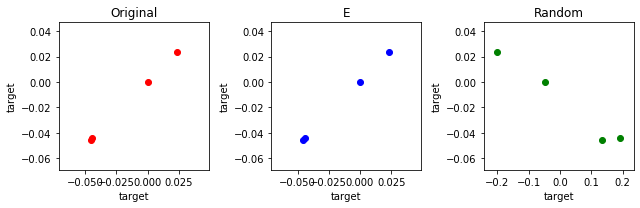

In [15]:
# Веса, полученные в ходе экспериментов

_, ax = plt.subplots(1, 3, figsize=(9,3))

for axi, matrix, c, title in zip(ax, 
                                 [feature_matrix, feature_matrix_eye, feature_matrix_rand], 
                                 ['r', 'b', 'g'], 
                                 ['Original', 'E', 'Random']):
    axi.scatter(
        get_weight(matrix, target_matrix),
        y=get_weight(feature_matrix, target_matrix),
        color=c
    )
    axi.set_xlabel('target')
    axi.set_ylabel('target')
    axi.set_title(title)
    
plt.tight_layout()
plt.show()

In [16]:
X3 = TSNE(n_components=3).fit_transform(feature_matrix)
X3_eye = TSNE(n_components=3).fit_transform(feature_matrix_eye)
X3_rand = TSNE(n_components=3).fit_transform(feature_matrix_rand)

print(X3.shape)
print(X3_eye.shape)
print(X3_rand.shape)

(5000, 3)
(5000, 3)
(5000, 3)


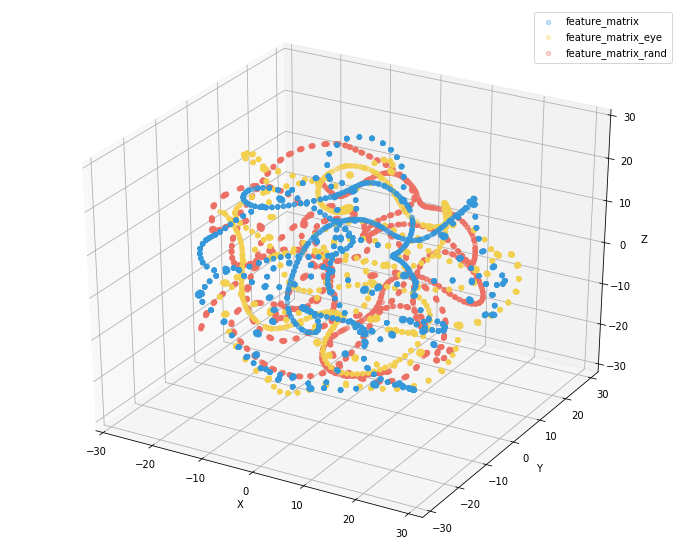

In [17]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3[:,0], X3[:,1], X3[:,2], color='#3498DB', alpha=0.3)
ax.scatter(X3_eye[:,0], X3_eye[:,1], X3_eye[:,2], color='#F4D04F', alpha=0.3)
ax.scatter(X3_rand[:,0], X3_rand[:,1], X3_rand[:,2], color='#EC7063', alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['feature_matrix', 'feature_matrix_eye', 'feature_matrix_rand'])
plt.show()

На графике видно, что после прообразования расположение признаков в пространстве совершенно изменилось.

## 3. Алгоритм преобразования

**Алгоритм**

В качестве алгоритма преобразования данных выбирается случайная матрица, которая является обратимой - *feature_matrix_rand*.

**Обоснование**

Алгоритм выбран, так как:
1. Данные меняются и их невозможно интепретировать и связать с реальными данными (цель задачи).
2. Матрица обратимая, следовательно, данные возжно расшифровать с помощью обратной матрицы преобразования.
3. Преобразование не влияет на качество модели, соответственно, не привносится искажение результатов работы модели.

## 4. Проверка алгоритма

In [18]:
print('До преобразования')
learn(feature_matrix, target_matrix, show_matrix=False)

До преобразования

R2: 0.42494550286668


In [19]:
print('После преобразования')
learn(feature_matrix_rand, target_matrix, show_matrix=False)

После преобразования

R2: 0.4249455028666801


## Вывод

Метрики качества моделей до и после преобразования признаков отличаются после 12 знака после запятой, что является несущественным отличием. Соответственно, выбранный алгоритм преобразования данных пригоден для шифрования данных без последствий для модели машинного обучения.